# Early stopping

In [62]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV, KFold, StratifiedKFold
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.datasets import make_friedman1
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
import json
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')
from utils import FriedmanDataset, run_kfold_visualizer, ModelOptimizerFinal 


In [58]:
# Data Creation
n_train= 1000
n_test= 100000
n_features = 10
FD_noise= 2
transformation='identity'
seed=100
np.random.seed(seed) # for selecting hyperparameters grid

# Stratification
n_groups = 10

# RandomSearchCV
n_folds = 5
n_iter= 4
n_repetitions=20
scoring= 'neg_mean_squared_error' 
n_jobs= -1

param_grid = {
    'learning_rate': np.linspace(0.001, 0.4, num =10), #default 0.3
    'max_depth':  [int(i) for i in np.logspace(np.log10(2), np.log10(20), num =20) ], # defualt 6
    'subsample': [np.random.uniform(0.5,1) for i in range(10)], # default 1
    'colsample_bytree': [np.random.uniform(0.5,1) for i in range(10)],# default 1
    'gamma': np.logspace(0, np.log10(20), num =10), #default 0
    'min_child_weight': np.arange(1, 10) #default 1
}
#'n_estimators': np.arange(100, 1000), #don't find it in parameters online (I think it depends on xgbosst version)
#'learning_rate': np.logspace(np.log10(0.001), np.log10(0.6), num =10), #default 0.3

# Initalize Model
modelOptimizer = ModelOptimizerFinal(xgb.XGBRegressor(random_state=seed), 
                                param_grid,
                                random_state=seed)

# Save Parameters in a dictionary
params = {'model': modelOptimizer.model.__class__.__name__,
          'n_train': n_train,
          'n_test': n_test,
          'n_features': n_features,
          'FD_noise': FD_noise,
          'transformation': transformation,
          'n_groups': n_groups,
          'n_folds': n_folds,
          'n_iter': n_iter,
          'n_repetitions': n_repetitions,
          'scoring': scoring, 
          'n_jobs': n_jobs}
params

{'model': 'XGBRegressor',
 'n_train': 1000,
 'n_test': 100000,
 'n_features': 10,
 'FD_noise': 2,
 'transformation': 'identity',
 'n_groups': 10,
 'n_folds': 5,
 'n_iter': 4,
 'n_repetitions': 20,
 'scoring': 'neg_mean_squared_error',
 'n_jobs': -1}

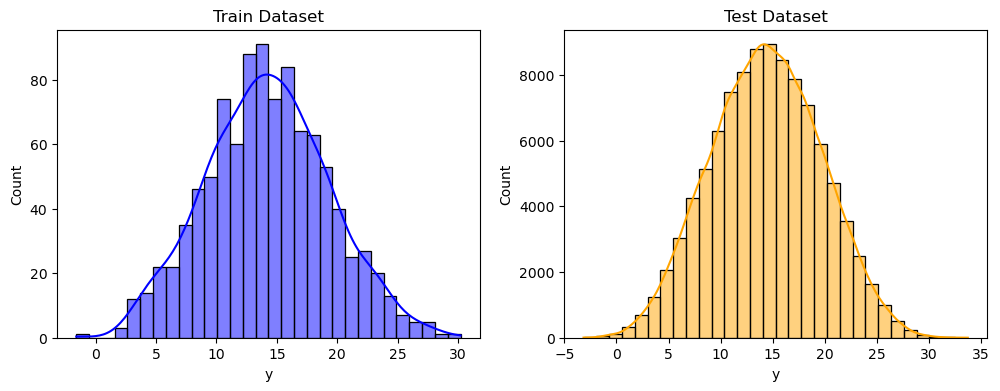

In [33]:
train = FriedmanDataset(n_samples=n_train, 
                            n_features=n_features, 
                            noise=FD_noise, 
                            random_state=42)
train.transform(transformation=transformation)

test = FriedmanDataset(n_samples=n_test,
                           n_features=n_features,
                           noise=FD_noise,
                           random_state=1718)
test.transform(transformation=transformation)


# Show here histograms of train and train datasets
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(train.df, x='y', bins=30, kde=True, ax=axes[0], color='blue')
axes[0].set_title('Train Dataset')

sns.histplot(test.df, x='y', bins=30, kde=True, ax=axes[1], color='orange')
axes[1].set_title('Test Dataset')

plt.show()

Split data into train, test and valdiation set.

In [34]:
# split data into X and y
X = train.df.drop('y', axis=1)
Y = train.df['y']
# split data into train and val sets
seed = 7
test_size = 0.3
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=test_size, random_state=seed)
# split val data into test and val
test_size = 0.5
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=test_size, random_state=seed)

print('Train shape: ', X_train.shape)
print('Val shape: ', X_val.shape)
print('Test shape: ', X_test.shape)

Train shape:  (700, 10)
Val shape:  (150, 10)
Test shape:  (150, 10)


Fitting without early stopping:

In [52]:
# without early stopping
from sklearn.model_selection import train_test_split

# fit model no training data
model = xgb.XGBRegressor(random_state=seed)
model.fit(X_train, y_train)

# calculate rmse on test set
y_pred = model.predict(X_test)
rmse_baseline = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %.3f" % rmse_baseline)




RMSE: 2.487


## With early stopping
* There are some heuristics that recommend to use 10% of your total iterations for early stopping, which sounds reasonable. (https://mljar.com/blog/xgboost-early-stopping/): early_stopping_rounds = 10% * n_estimators, e.g. 1000 and 50
* early_stopping_rounds parameter for controlling the patience of how many iterations we will wait for the next decrease in the loss value

With early stopping (version 1): https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/

In [53]:
model = xgb.XGBRegressor(random_state=seed)
eval_set = [(X_val, y_val)]
model.fit(X_train, y_train, early_stopping_rounds=10, eval_set=eval_set, verbose=True)

# calculate rmse on test set
y_pred = model.predict(X_test)
rmse_es1 = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %.3f" % rmse_es1)


[0]	validation_0-rmse:3.96019


[1]	validation_0-rmse:3.47359
[2]	validation_0-rmse:3.14025
[3]	validation_0-rmse:2.89415
[4]	validation_0-rmse:2.75524
[5]	validation_0-rmse:2.66269
[6]	validation_0-rmse:2.61005
[7]	validation_0-rmse:2.57639
[8]	validation_0-rmse:2.52969
[9]	validation_0-rmse:2.52362
[10]	validation_0-rmse:2.51043
[11]	validation_0-rmse:2.50364
[12]	validation_0-rmse:2.50169
[13]	validation_0-rmse:2.51123
[14]	validation_0-rmse:2.50971
[15]	validation_0-rmse:2.49673
[16]	validation_0-rmse:2.49360
[17]	validation_0-rmse:2.48514
[18]	validation_0-rmse:2.47368
[19]	validation_0-rmse:2.46428
[20]	validation_0-rmse:2.46895
[21]	validation_0-rmse:2.47572
[22]	validation_0-rmse:2.48833
[23]	validation_0-rmse:2.48953
[24]	validation_0-rmse:2.49713
[25]	validation_0-rmse:2.49453
[26]	validation_0-rmse:2.49389
[27]	validation_0-rmse:2.49890
[28]	validation_0-rmse:2.49791
RMSE: 2.493


With early stopping (version 1): https://mljar.com/blog/xgboost-early-stopping/

In [55]:
model = xgb.XGBRegressor(n_estimators=100, max_depth=6, 
                         learning_rate=0.1, early_stopping_rounds=30)
#model.fit(X_train, y_train, early_stopping_rounds=10, eval_set=eval_set, verbose=True)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])

# calculate rmse on test set
y_pred = model.predict(X_test)
rmse_es2 = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %.3f" % rmse_es2)

[0]	validation_0-rmse:4.71758	validation_1-rmse:4.50385


[1]	validation_0-rmse:4.37541	validation_1-rmse:4.22445
[2]	validation_0-rmse:4.06831	validation_1-rmse:4.01430
[3]	validation_0-rmse:3.79689	validation_1-rmse:3.77768
[4]	validation_0-rmse:3.54841	validation_1-rmse:3.59502
[5]	validation_0-rmse:3.32024	validation_1-rmse:3.43946
[6]	validation_0-rmse:3.11099	validation_1-rmse:3.29204
[7]	validation_0-rmse:2.91932	validation_1-rmse:3.18329
[8]	validation_0-rmse:2.74792	validation_1-rmse:3.06845
[9]	validation_0-rmse:2.59127	validation_1-rmse:2.98460
[10]	validation_0-rmse:2.44329	validation_1-rmse:2.92987
[11]	validation_0-rmse:2.31321	validation_1-rmse:2.86624
[12]	validation_0-rmse:2.18844	validation_1-rmse:2.81500
[13]	validation_0-rmse:2.08130	validation_1-rmse:2.76334
[14]	validation_0-rmse:1.97998	validation_1-rmse:2.70410
[15]	validation_0-rmse:1.88863	validation_1-rmse:2.67698
[16]	validation_0-rmse:1.80469	validation_1-rmse:2.64560
[17]	validation_0-rmse:1.72648	validation_1-rmse:2.61380
[18]	validation_0-rmse:1.65863	validatio

Text(79, 4.933021930798292, 'optimal numer of trees: 80')

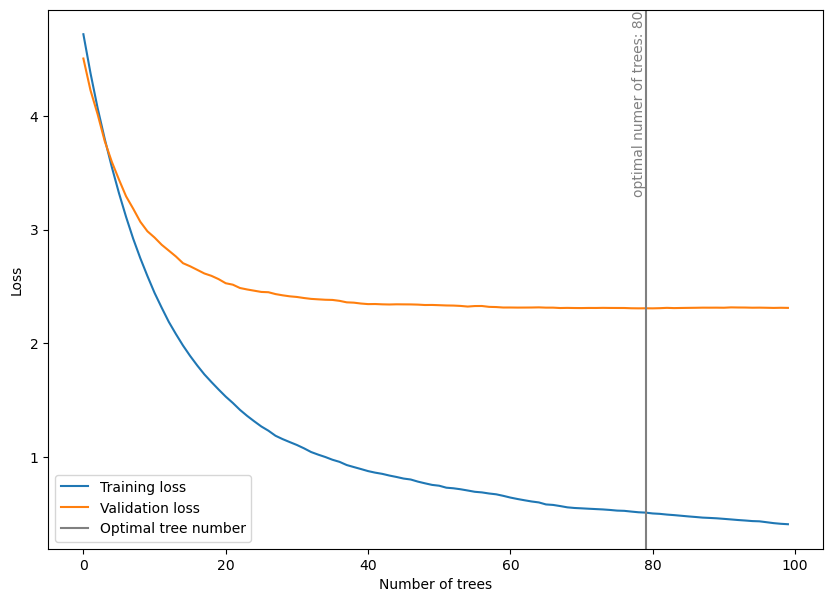

In [56]:
results = model.evals_result()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.axvline(model.best_iteration - 1, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

# Add label to axvline
plt.text(model.best_iteration - 1, plt.ylim()[1], f"optimal numer of trees: {model.best_iteration}", 
         color="gray", ha="right", va="top", rotation=90)


In [57]:
# Overview RMSE resutls
print('RMSE baseline: ', rmse_baseline)
print('RMSE early stopping 1: ', rmse_es1)
print('RMSE early stopping 2: ', rmse_es2)

RMSE baseline:  2.4865354582227632
RMSE early stopping 1:  2.4929260361472405
RMSE early stopping 2:  2.3253036303441883


## Random Search
Random Search without early stopping

In [68]:
xgb_model = xgb.XGBRegressor(random_state=30)

grid_obj_xgb = RandomizedSearchCV(xgb_model,param_grid, cv=5,n_iter=n_iter,scoring='neg_mean_absolute_error',verbose=5,n_jobs=-1)
grid_obj_xgb.fit(X_train, y_train,verbose = 1)

#y_pred_train = grid_obj_xgb.predict(X_train)
#y_pred_test = grid_obj_xgb.predict(X_test)
#err_xgb_train=mean_absolute_error(y_train, y_pred_train, multioutput='raw_values')
#err_xgb_train


# calculate rmse on test set
y_pred = grid_obj_xgb.predict(X_test)
rmse_rs = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %.3f" % rmse_rs)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 2/5] END colsample_bytree=0.945660977156132, gamma=14.337423288737734, learning_rate=0.17833333333333334, max_depth=2, min_child_weight=8, subsample=0.5023594280954863;, score=-1.863 total time=   0.0s
[CV 1/5] END colsample_bytree=0.945660977156132, gamma=14.337423288737734, learning_rate=0.17833333333333334, max_depth=2, min_child_weight=8, subsample=0.5023594280954863;, score=-1.898 total time=   0.0s
[CV 3/5] END colsample_bytree=0.945660977156132, gamma=14.337423288737734, learning_rate=0.17833333333333334, max_depth=2, min_child_weight=8, subsample=0.5023594280954863;, score=-2.017 total time=   0.0s
[CV 5/5] END colsample_bytree=0.945660977156132, gamma=14.337423288737734, learning_rate=0.17833333333333334, max_depth=2, min_child_weight=8, subsample=0.5023594280954863;, score=-2.061 total time=   0.0s
[CV 4/5] END colsample_bytree=0.945660977156132, gamma=14.337423288737734, learning_rate=0.17833333333333334, max_de

/Users/nadja/miniconda3/envs/slds_env310/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/nadja/miniconda3/envs/slds_env310/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/nadja/miniconda3/envs/slds_env310/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/nadja/miniconda3/envs/slds_env310/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future vers

Random Search with early stopping

In [ ]:
model = xgb.XGBRegressor(n_estimators=100, max_depth=6, 
                         learning_rate=0.1, early_stopping_rounds=30)
#model.fit(X_train, y_train, early_stopping_rounds=10, eval_set=eval_set, verbose=True)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])

In [71]:
fit_params={"early_stopping_rounds":42, 
            "eval_metric" : "mae", 
            "eval_set" : [[X_val, y_val]]}


In [93]:
xgb_model = xgb.XGBRegressor(random_state=30)

grid_obj_xgb = RandomizedSearchCV(xgb_model, param_grid, cv=5, scoring='neg_mean_absolute_error',verbose=1, n_jobs=-1)
grid_obj_xgb.fit(X_train, y_train,verbose = 1, **fit_params,)

#y_pred_train = grid_obj_xgb.predict(X_train)
#y_pred_test = grid_obj_xgb.predict(X_test)
#err_xgb_train=mean_absolute_error(y_train, y_pred_train, multioutput='raw_values')
#err_xgb_train


# calculate rmse on test set
y_pred = grid_obj_xgb.predict(X_test)
rmse_rs = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %.3f" % rmse_rs)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/nadja/miniconda3/envs/slds_env310/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/nadja/miniconda3/envs/slds_env310/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/nadja/miniconda3/envs/slds_env310/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/nadja/miniconda3/envs/slds_env310/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

[0]	validation_0-mae:3.30696
[0]	validation_0-mae:3.38679
[0]	validation_0-mae:3.25639
[0]	validation_0-mae:3.38257
[1]	validation_0-mae:3.02049
[0]	validation_0-mae:3.38094
[0]	validation_0-mae:3.39389
[1]	validation_0-mae:3.17677
[2]	validation_0-mae:2.94538
[0]	validation_0-mae:3.40761
[2]	validation_0-mae:2.90063
[3]	validation_0-mae:2.65763
[4]	validation_0-mae:2.57622
[1]	validation_0-mae:3.23982
[1]	validation_0-mae:3.16941
[1]	validation_0-mae:3.18978
[1]	validation_0-mae:3.18441
[5]	validation_0-mae:2.51054
[3]	validation_0-mae:2.65370
[6]	validation_0-mae:2.45988
[2]	validation_0-mae:2.97882
[1]	validation_0-mae:3.10777
[4]	validation_0-mae:2.51949
[2]	validation_0-mae:3.03153
[2]	validation_0-mae:2.90618
[5]	validation_0-mae:2.45045
[3]	validation_0-mae:2.70229
[3]	validation_0-mae:2.66251
[2]	validation_0-mae:3.13845
[6]	validation_0-mae:2.38353
[4]	validation_0-mae:2.54656
[0]	validation_0-mae:3.37122
[4]	validation_0-mae:2.57858
[7]	validation_0-mae:2.40609
[5]	validation

/Users/nadja/miniconda3/envs/slds_env310/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/nadja/miniconda3/envs/slds_env310/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/nadja/miniconda3/envs/slds_env310/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/nadja/miniconda3/envs/slds_env310/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better c

[47]	validation_0-mae:2.45869
[44]	validation_0-mae:2.40759
[51]	validation_0-mae:2.37003
[52]	validation_0-mae:2.36337
[48]	validation_0-mae:2.45429
[45]	validation_0-mae:2.40178
[42]	validation_0-mae:2.44637

[53]	validation_0-mae:2.36076
[49]	validation_0-mae:2.43495
[46]	validation_0-mae:2.39755
[54]	validation_0-mae:2.35096
[50]	validation_0-mae:2.41902
[47]	validation_0-mae:2.38909
[43]	validation_0-mae:2.43808
[55]	validation_0-mae:2.34530
[48]	validation_0-mae:2.37980
[15]	validation_0-mae:2.39141[44]	validation_0-mae:2.43425

[16]	validation_0-mae:2.39113
[17]	validation_0-mae:2.38595
[56]	validation_0-mae:2.33028
[0]	validation_0-mae:3.28227
[49]	validation_0-mae:2.36391
[18]	validation_0-mae:2.37982
[19]	validation_0-mae:2.37888
[20]	validation_0-mae:2.37961
[21]	validation_0-mae:2.39443
[22]	validation_0-mae:2.39064
[50]	validation_0-mae:2.35425
[57]	validation_0-mae:2.32507
[23]	validation_0-mae:2.39261
[24]	validation_0-mae:2.38354
[25]	validation_0-mae:2.38599
[26]	valid

/Users/nadja/miniconda3/envs/slds_env310/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/nadja/miniconda3/envs/slds_env310/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/nadja/miniconda3/envs/slds_env310/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/nadja/miniconda3/envs/slds_env310/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version.

[10]	validation_0-mae:2.12154
[48]	validation_0-mae:1.94541
[11]	validation_0-mae:2.10163
[61]	validation_0-mae:1.95116
[49]	validation_0-mae:1.93215
[49]	validation_0-mae:1.93884
[0]	validation_0-mae:3.87436
[12]	validation_0-mae:2.10739
[50]	validation_0-mae:1.94428
[13]	validation_0-mae:2.08626
[14]	validation_0-mae:2.08463
[50]	validation_0-mae:1.92776
[62]	validation_0-mae:1.95006
[2]	validation_0-mae:3.18079
[51]	validation_0-mae:1.94352
[1]	validation_0-mae:3.87276
[15]	validation_0-mae:2.07065
[16]	validation_0-mae:2.05156
[63]	validation_0-mae:1.94809
[51]	validation_0-mae:1.92283
[17]	validation_0-mae:2.06972
[64]	validation_0-mae:1.95184
[3]	validation_0-mae:2.97499
[18]	validation_0-mae:2.06918
[19]	validation_0-mae:2.07747
[20]	validation_0-mae:2.07026
[2]	validation_0-mae:3.87109
[52]	validation_0-mae:1.95317
[72]	validation_0-mae:1.93407
[4]	validation_0-mae:2.69058
[5]	validation_0-mae:3.87198
[73]	validation_0-mae:1.93254
[65]	validation_0-mae:1.95287
[74]	validation_0

/Users/nadja/miniconda3/envs/slds_env310/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/nadja/miniconda3/envs/slds_env310/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/nadja/miniconda3/envs/slds_env310/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/nadja/miniconda3/envs/slds_env310/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future vers

[9]	validation_0-mae:2.19946
[52]	validation_0-mae:3.76697
[30]	validation_0-mae:3.80761
[32]	validation_0-mae:3.80198
[31]	validation_0-mae:3.80483
[24]	validation_0-mae:3.82361
[53]	validation_0-mae:3.76426
[33]	validation_0-mae:3.79947
[15]	validation_0-mae:2.13685
[43]	validation_0-mae:3.77830
[25]	validation_0-mae:3.82094
[34]	validation_0-mae:3.79678
[11]	validation_0-mae:1.95872
[35]	validation_0-mae:3.79444
[16]	validation_0-mae:2.13102
[12]	validation_0-mae:1.93671
[13]	validation_0-mae:1.91991
[36]	validation_0-mae:3.79239
[26]	validation_0-mae:3.81820
[14]	validation_0-mae:1.91648
[15]	validation_0-mae:1.91113
[16]	validation_0-mae:1.90774
[37]	validation_0-mae:3.79055
[17]	validation_0-mae:1.90382
[27]	validation_0-mae:3.81568
[18]	validation_0-mae:1.88934
[17]	validation_0-mae:2.12942
[38]	validation_0-mae:3.78840
[19]	validation_0-mae:1.87873
[28]	validation_0-mae:3.81353
[20]	validation_0-mae:1.87868
[21]	validation_0-mae:1.87098
[39]	validation_0-mae:3.78585
[22]	valida

/Users/nadja/miniconda3/envs/slds_env310/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/nadja/miniconda3/envs/slds_env310/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/nadja/miniconda3/envs/slds_env310/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/nadja/miniconda3/envs/slds_env310/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future vers

[62]	validation_0-mae:2.16638
[59]	validation_0-mae:2.00306
[63]	validation_0-mae:2.16639
[97]	validation_0-mae:2.17311
[13]	validation_0-mae:2.36406
[64]	validation_0-mae:2.16323
[65]	validation_0-mae:2.16303
[98]	validation_0-mae:2.17249
[14]	validation_0-mae:2.36779
[66]	validation_0-mae:2.16573
[99]	validation_0-mae:2.17053
[67]	validation_0-mae:2.17013
[68]	validation_0-mae:2.16969
[69]	validation_0-mae:2.17137
[70]	validation_0-mae:2.17143
[71]	validation_0-mae:2.17270
[15]	validation_0-mae:2.32660
[72]	validation_0-mae:2.17221
[73]	validation_0-mae:2.17450
[74]	validation_0-mae:2.17290
[75]	validation_0-mae:2.17448
[76]	validation_0-mae:2.17388
[16]	validation_0-mae:2.30170
[77]	validation_0-mae:2.17423
[78]	validation_0-mae:2.17337
[79]	validation_0-mae:2.17331
[80]	validation_0-mae:2.17277
[17]	validation_0-mae:2.29241
[81]	validation_0-mae:2.17252
[18]	validation_0-mae:2.29671
[19]	validation_0-mae:2.28508
[74]	validation_0-mae:2.05812
[20]	validation_0-mae:2.28595
[60]	valid